### Universal Imports

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

## Data Preprocessing/Feature Engineering

In [15]:
all_data = pd.read_csv("data/data.csv")
all_data = all_data[all_data["Phase"] == 3]

# excluded 3 participants because of incomplete data
all_data = all_data[all_data["Participant"] != 2]
all_data = all_data[all_data["Participant"] != 8]
all_data = all_data[all_data["Participant"] != 9]

all_data.head()

,Row,Participant,Phase,Day,Date,MET_Session,Exercise_Duration_Total,Exercise_METmin_Total,%Complete_total,Mean_total,...,Unnamed: 136,Unnamed: 137,Unnamed: 138,Unnamed: 139,Unnamed: 140,Unnamed: 141,Unnamed: 142,Unnamed: 143,Unnamed: 144,Unnamed: 145
28,29,1,3,1,1/13/20,0,0,0.0,74.3,165.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,30,1,3,2,1/14/20,0,0,0.0,100.0,138.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,31,1,3,3,1/15/20,0,26,72.8,100.0,120.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,32,1,3,4,1/16/20,0,0,0.0,100.0,159.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,33,1,3,5,1/17/20,0,0,0.0,100.0,181.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# feature extraction

features = ["Participant", 
            "Day", 
            "Date",
            "Sick", 
            "Morning Fear of Hypoglycemia",
            "Evening Fear of Hypoglycemia", 
            "Sleep Quality", 
            "Mean_total", 
            "CV_total", 
            "Time High (%)_total", 
            "Time In Range (%)_total", 
            "Time Low (%)_total", 
            "Mean_daytime",
            "CV_daytime",
            "Time High (%)_daytime",
            "Time In Range (%)_daytime",
            "Time Low (%)_daytime",
            "Mean_nighttime", 
            "CV_nighttime",
            "Time High (%)_nighttime",
            "Time In Range (%)_nighttime",
            "# of times hypoglycemic",
            "Time Low (%)_nighttime", "Exercise_METmin_Total"]

df = all_data[features]
df["y"] = [int(exercise > 0) for exercise in df["Exercise_METmin_Total"]]
df = df.drop('Exercise_METmin_Total', axis=1)
df.head()

,Participant,Day,Date,Sick,Morning Fear of Hypoglycemia,Evening Fear of Hypoglycemia,Sleep Quality,Mean_total,CV_total,Time High (%)_total,...,Time High (%)_daytime,Time In Range (%)_daytime,Time Low (%)_daytime,Mean_nighttime,CV_nighttime,Time High (%)_nighttime,Time In Range (%)_nighttime,# of times hypoglycemic,Time Low (%)_nighttime,y
28,1,1,1/13/20,0,.,1,6,165.2,39.4,27.6,...,50.0,50.0,0.0,126.9,26.8,0.0,95.8,0,4.2,0
29,1,2,1/14/20,0,1,1,7,138.8,39.0,16.0,...,22.4,66.7,10.9,134.9,17.5,3.1,96.9,1,0.0,0
30,1,3,1/15/20,0,1,1,7,120.9,23.4,2.4,...,3.6,96.4,0.0,111.6,23.8,0.0,94.8,0,5.2,1
31,1,4,1/16/20,0,1,1,6,159.9,34.6,41.0,...,26.6,64.6,8.9,204.2,16.0,69.8,30.2,0,0.0,0
32,1,5,1/17/20,0,1,1,3,181.6,42.9,41.3,...,21.4,78.6,0.0,253.0,26.0,81.3,18.8,0,0.0,0


In [17]:
# fix sleep, sick , and FOH data
participant_lookup = list(df["Participant"])

def fix_sick_data(df):
    sick_data = []
    sick_lookup = list(df["Sick"])
    
    for index, row in enumerate(sick_lookup):
        if row != '.':
            if row == '2':
                row = '0'
            sick_data.append(int(row))
        else:
            curr = participant_lookup[index]
            
            # Check the last 3 days 
            val = 0
            for look_back_day in range(1, 3+1):
                temp_idx = index - look_back_day
                
                if temp_idx < 0 or participant_lookup[temp_idx] != curr:
                    break
                        
                if sick_lookup[temp_idx] == '1':
                    val = 1
                    break
                    
            sick_data.append(val)
    
    df["Sick"] = sick_data
    
    return df

def clean_foh(df):
    df.loc[df["Morning Fear of Hypoglycemia"] == ".", "Morning Fear of Hypoglycemia"] = 1
    df.loc[df["Evening Fear of Hypoglycemia"] == ".", "Evening Fear of Hypoglycemia"] = 1
    return df 

def fix_sleep_data(df):
    sleep_data = []
    sleep_lookup = list(df["Sleep Quality"])

    for index, row in enumerate(sleep_lookup):
        if row != '.':
            sleep_data.append(int(row))
        else:
            curr = participant_lookup[index]

            if participant_lookup[index-1] == curr and sleep_lookup[index-1] != '.':
                if participant_lookup[index+1] == curr and sleep_lookup[index+1] != '.':
                    avg = (int(sleep_lookup[index-1]) + int(sleep_lookup[index+1])) / 2
                    sleep_data.append(avg)
                else:
                    sleep_data.append(int(sleep_lookup[index-1]))
            elif participant_lookup[index+1] == curr and sleep_lookup[index+1] != '.':
                sleep_data.append(int(sleep_lookup[index+1]))
            else:
                df_curr = df[df["Participant"] == curr]
                df_curr = df_curr[df_curr['Sleep Quality'] != '.']
                average_sleep_quality = df_curr['Sleep Quality'].astype(int).mean()
                sleep_data.append(average_sleep_quality)

    df["Sleep Quality"] = sleep_data
    
    return df

df = fix_sick_data(df)
df = fix_sleep_data(df)
df = clean_foh(df)

# drop non-numerical/invalid rows 
for class_name in features:
    if class_name != "Date" and class_name != "Exercise_METmin_Total":
        df = df[pd.to_numeric(df[class_name], errors='coerce').notnull()]
df = df.dropna()
df

,Participant,Day,Date,Sick,Morning Fear of Hypoglycemia,Evening Fear of Hypoglycemia,Sleep Quality,Mean_total,CV_total,Time High (%)_total,...,Time High (%)_daytime,Time In Range (%)_daytime,Time Low (%)_daytime,Mean_nighttime,CV_nighttime,Time High (%)_nighttime,Time In Range (%)_nighttime,# of times hypoglycemic,Time Low (%)_nighttime,y
28,1,1,1/13/20,0,1,1,6.0,165.2,39.4,27.6,...,50.0,50.0,0.0,126.9,26.8,0.0,95.8,0,4.2,0
29,1,2,1/14/20,0,1,1,7.0,138.8,39.0,16.0,...,22.4,66.7,10.9,134.9,17.5,3.1,96.9,1,0.0,0
30,1,3,1/15/20,0,1,1,7.0,120.9,23.4,2.4,...,3.6,96.4,0.0,111.6,23.8,0.0,94.8,0,5.2,1
31,1,4,1/16/20,0,1,1,6.0,159.9,34.6,41.0,...,26.6,64.6,8.9,204.2,16.0,69.8,30.2,0,0.0,0
32,1,5,1/17/20,0,1,1,3.0,181.6,42.9,41.3,...,21.4,78.6,0.0,253.0,26.0,81.3,18.8,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1959,23,65,11/6/20,0,1,1,7.0,145.8355556,30.04585913,28,...,34.39490446,64.96815287,0.636942675,132.0147059,24.21480015,13.23529412,86.76470588,0,0,0
1960,23,66,11/7/20,0,1,2,5.0,115.9965035,21.80354914,0,...,0,98.94736842,1.052631579,121.6354167,20.46845493,0,100,3,0,1
1962,23,68,11/9/20,0,1,1,4.0,159.5774059,25.57146553,28.87029289,...,37.41496599,62.58503401,0,146.7282609,22.30656326,15.2173913,84.7826087,0,0,0
1963,23,69,11/10/20,0,1,1,5.0,130.8958333,20.96629896,5.555555556,...,8.333333333,91.66666667,0,124.84375,14.58212679,0,100,0,0,0


In [18]:
def shift_df(df, all_features, non_shifted_col_names):
    new_data = {}
    
    for col_name in non_shifted_col_names:
        col_data = []
        for p_number in df['Participant'].unique():
            temp_df = df[df["Participant"] == p_number]
            curr_data = list(temp_df[col_name])
            curr_data = curr_data[1:]
            col_data.extend(curr_data)
        new_data[col_name] = col_data
    
    for col_name in all_features:
        if col_name in non_shifted_col_names:
            continue
        col_data = []
        for p_number in df['Participant'].unique():
            temp_df = df[df["Participant"] == p_number]
            curr_data = list(temp_df[col_name])
            col_data.extend(curr_data[:-1])  
        new_data[col_name] = col_data
    return pd.DataFrame(new_data)

df = shift_df(df, list(df.columns), set(["y", "Sick", "Morning Fear of Hypoglycemia", "Date"]))

In [19]:
new_features = pd.read_csv("novelFeatures.csv")
new_features["Date"] = pd.to_datetime(new_features['Date']).dt.strftime('%m/%d/%y')

def my_new_feature_df(path, numb):
    ex = pd.read_csv(path)
    ex["Date"] = pd.to_datetime(ex['Date']).dt.strftime('%m/%d/%y')
    ex["Participant"] = float(numb)
    return ex

new_feature_p1 = my_new_feature_df("data/new_features_p1.csv", 6)
new_feature_p2 = my_new_feature_df("data/new_features_p2.csv", 10)
new_feature_p3 = my_new_feature_df("data/new_features_p3.csv", 11)
new_feature_p4 = my_new_feature_df("data/new_features_p4.csv", 15)

add_feature = pd.concat([new_feature_p1, new_feature_p2, new_feature_p3, new_feature_p4])
new_features = pd.concat([new_features, add_feature])

new_features["Feature1"] = new_features["Feature1"].astype(int)
new_features["Feature2"] = new_features["Feature2"].astype(int)
new_features["Feature3"] = new_features["Feature3"].astype(int)
new_features["Feature4"] = new_features["Feature4"].astype(int)
new_features["Participant"] = new_features["Participant"].astype(int)

new_feature_lookup = []
for i in range(0, 24):
    new_feature_lookup.append({})
    
for index, row in new_features.iterrows():
    curr_p_idx = row['Participant']
    val = [row['Feature1'], row['Feature2'], row['Feature3'], row['Feature4']]
    new_feature_lookup[curr_p_idx][row['Date']] = val
    
new_features

/var/folders/mt/_h1gs1415tndr_r6m8062k940000gn/T/ipykernel_3292/2832895686.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ex["Date"] = pd.to_datetime(ex['Date']).dt.strftime('%m/%d/%y')
/var/folders/mt/_h1gs1415tndr_r6m8062k940000gn/T/ipykernel_3292/2832895686.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ex["Date"] = pd.to_datetime(ex['Date']).dt.strftime('%m/%d/%y')


,Participant,Date,Feature1,Feature2,Feature3,Feature4
0,1,01/15/20,0,0,0,0
1,1,01/20/20,0,0,0,0
2,1,01/23/20,0,0,1,0
3,1,01/30/20,1,0,0,0
4,1,02/06/20,0,1,1,0
...,...,...,...,...,...,...
61,15,09/10/20,0,0,0,0
62,15,09/11/20,0,0,0,0
63,15,09/12/20,0,0,0,0
64,15,09/13/20,0,0,0,0


In [20]:
df["Date"] = pd.to_datetime(df['Date']).dt.strftime('%m/%d/%y')
df = pd.merge(new_features, df, on=['Participant', 'Date'], how='right')
columns_to_replace = ['Feature1', 'Feature2', 'Feature3', 'Feature4']
df[columns_to_replace] = df[columns_to_replace].fillna(0)
# new_column_names = {'Feature1': 'NewName1', 'Feature2': 'NewName2', 'Feature3': 'NewName3', 'Feature4': 'NewName4'}
# df_with_new_features = df_with_new_features.rename(columns=new_column_names)
df

/var/folders/mt/_h1gs1415tndr_r6m8062k940000gn/T/ipykernel_3292/29362626.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df['Date']).dt.strftime('%m/%d/%y')


,Participant,Date,Feature1,Feature2,Feature3,Feature4,y,Morning Fear of Hypoglycemia,Sick,Day,...,CV_daytime,Time High (%)_daytime,Time In Range (%)_daytime,Time Low (%)_daytime,Mean_nighttime,CV_nighttime,Time High (%)_nighttime,Time In Range (%)_nighttime,# of times hypoglycemic,Time Low (%)_nighttime
0,1,01/14/20,0.0,0.0,0.0,0.0,0,1,0,1,...,34.5,50.0,50.0,0.0,126.9,26.8,0.0,95.8,0,4.2
1,1,01/15/20,0.0,0.0,0.0,0.0,1,1,0,2,...,45.5,22.4,66.7,10.9,134.9,17.5,3.1,96.9,1,0.0
2,1,01/16/20,0.0,0.0,0.0,0.0,0,1,0,3,...,22.3,3.6,96.4,0.0,111.6,23.8,0.0,94.8,0,5.2
3,1,01/17/20,0.0,0.0,0.0,0.0,0,1,0,4,...,36.8,26.6,64.6,8.9,204.2,16.0,69.8,30.2,0,0.0
4,1,01/18/20,0.0,0.0,0.0,0.0,0,1,0,5,...,38.5,21.4,78.6,0.0,253.0,26.0,81.3,18.8,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,23,11/06/20,0.0,0.0,0.0,0.0,0,1,0,64,...,26.46837193,33.15789474,66.84210526,0,121.0104167,18.24557152,0,100,0,0
1016,23,11/07/20,1.0,0.0,0.0,0.0,1,1,0,65,...,30.88492911,34.39490446,64.96815287,0.636942675,132.0147059,24.21480015,13.23529412,86.76470588,0,0
1017,23,11/09/20,0.0,0.0,0.0,0.0,0,1,0,66,...,22.15997078,0,98.94736842,1.052631579,121.6354167,20.46845493,0,100,3,0
1018,23,11/10/20,0.0,0.0,0.0,0.0,0,1,0,68,...,25.85091061,37.41496599,62.58503401,0,146.7282609,22.30656326,15.2173913,84.7826087,0,0


In [ ]:
# Import necessary libraries
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters
from tsfresh.feature_selection import select_features
from tsfresh.utilities.dataframe_functions import roll_time_series

column_types = {col: float for col in df.columns if col != 'Date'}
df = df.astype(column_types)

df_rolled = roll_time_series(df, column_id="Participant", column_sort="Date")

df_rolled = df_rolled.drop("Participant", axis=1)
df_rolled = df_rolled.drop("y", axis=1)

# Define the parameters for feature extraction
extraction_settings = EfficientFCParameters()

extracted_features = extract_features(
    df_rolled,
    column_id="id",
    column_sort="Date",
    default_fc_parameters=extraction_settings,
)

Feature Extraction:   0%|                                | 0/40 [00:00<?, ?it/s]

In [ ]:
extracted_features.dropna(axis=1)

In [ ]:
extracted_features = extracted_features.reset_index()
extracted_features.rename(columns={'level_0': 'Participant', 'level_1': 'Date'}, inplace=True)

extracted_features["Date"] = pd.to_datetime(extracted_features["Date"])
df["Date"] = pd.to_datetime(df["Date"])

extracted_features = pd.merge(extracted_features, df.drop("y", axis=1), on =['Participant', 'Date'])

In [ ]:
extracted_features_clean = extracted_features.dropna(axis=1).reset_index(drop=True)
target = np.array(df["y"].astype(int))

selected_features = select_features(extracted_features_clean, target, fdr_level=0.05)

selected_features["Participant"] = list(df["Participant"])
selected_features["Date"] = list(df["Date"])
selected_features["y"] = list(df["y"])
selected_features = selected_features.dropna(axis=1)
selected_features

In [ ]:
#demographic features
demoInfo = pd.read_csv("demographicInfo.csv")

def one_hot_encode(df, col_name, drop_it=True):
    one_hot = pd.get_dummies(df[col_name], prefix=col_name)
    df = df.join(one_hot)
    if drop_it:
        df = df.drop(col_name,axis = 1)
    return df 

def convert_to_binary(df, col_name):
    df[col_name] = df[col_name].replace(1,0)
    df[col_name] = df[col_name].replace(2,1)
    return df
    
# demoInfo = one_hot_encode(demoInfo, "Participant", False)
demoInfo = one_hot_encode(demoInfo, "Income")
demoInfo = convert_to_binary(demoInfo, "Therapy")
demoInfo = convert_to_binary(demoInfo, "RaceEthnicity")

df = pd.merge(selected_features, demoInfo, on='Participant')

df

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
days = list(df["Date"])
day_of_week = [day.weekday() for day in days]
df["dayOfWeek"] = day_of_week

def one_hot_encode(df, col_name, drop_it=True):
    one_hot = pd.get_dummies(df[col_name], prefix=col_name)
    df = df.join(one_hot)
    if drop_it:
        df = df.drop(col_name,axis = 1)
    return df 

def convert_to_binary(df, col_name):
    df[col_name] = df[col_name].replace(1,0)
    df[col_name] = df[col_name].replace(2,1)
    return df

df = one_hot_encode(df, "dayOfWeek", drop_it=True)
df

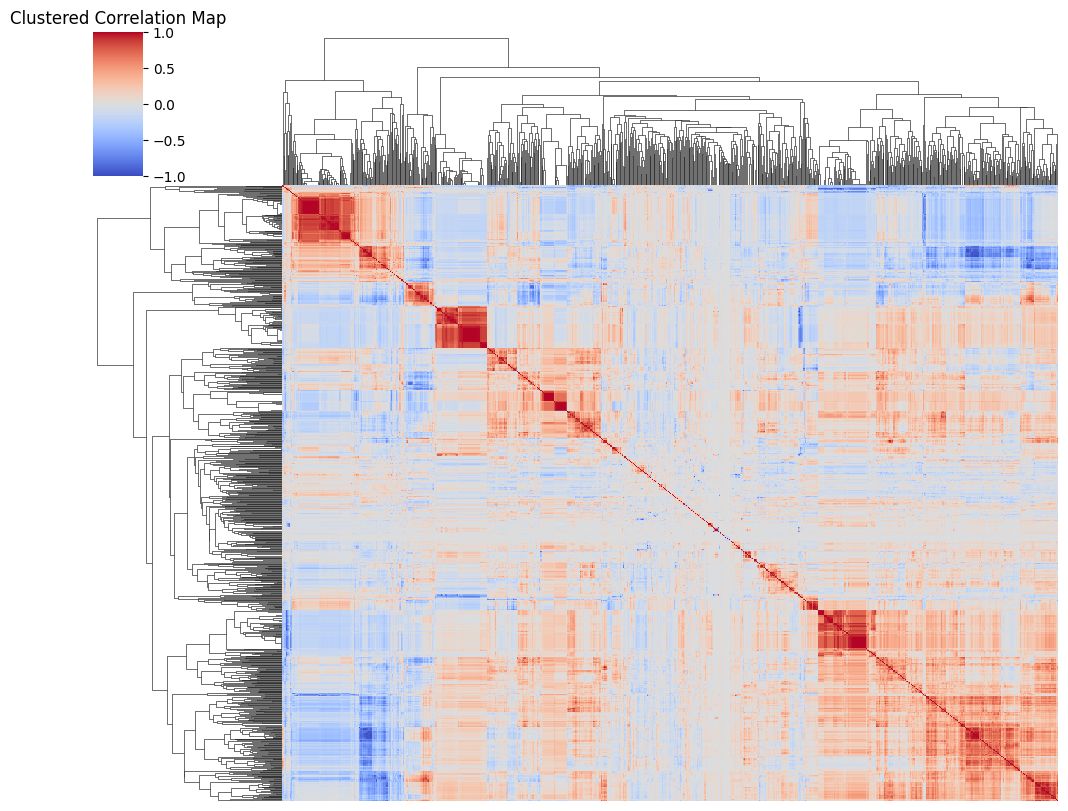

In [444]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = df.drop(["RaceEthnicity", "Income_2"], axis=1).corr()
correlation_matrix.dropna(inplace=True)

# Set a threshold for correlation (adjust as needed)
threshold = 0.3  # You can change this threshold value

# Create a mask to select highly correlated features
highly_correlated = (correlation_matrix.abs() >= threshold) | (correlation_matrix.abs() <= -threshold)

# # Apply the mask to the correlation matrix
# correlation_matrix_filtered = correlation_matrix.where(highly_correlated)

# # Replace NaN values in the filtered correlation matrix with 0
# correlation_matrix_filtered.fillna(0.01, inplace=True)

# Create a clustermap to visualize the filtered correlation matrix with clustering
sns.clustermap(correlation_matrix, cmap='coolwarm', figsize=(10, 8), annot=False,
               row_cluster=True, col_cluster=True,
               xticklabels=False, yticklabels=False)  # Set xticklabels and yticklabels to False
plt.title('Clustered Correlation Map')
plt.show()

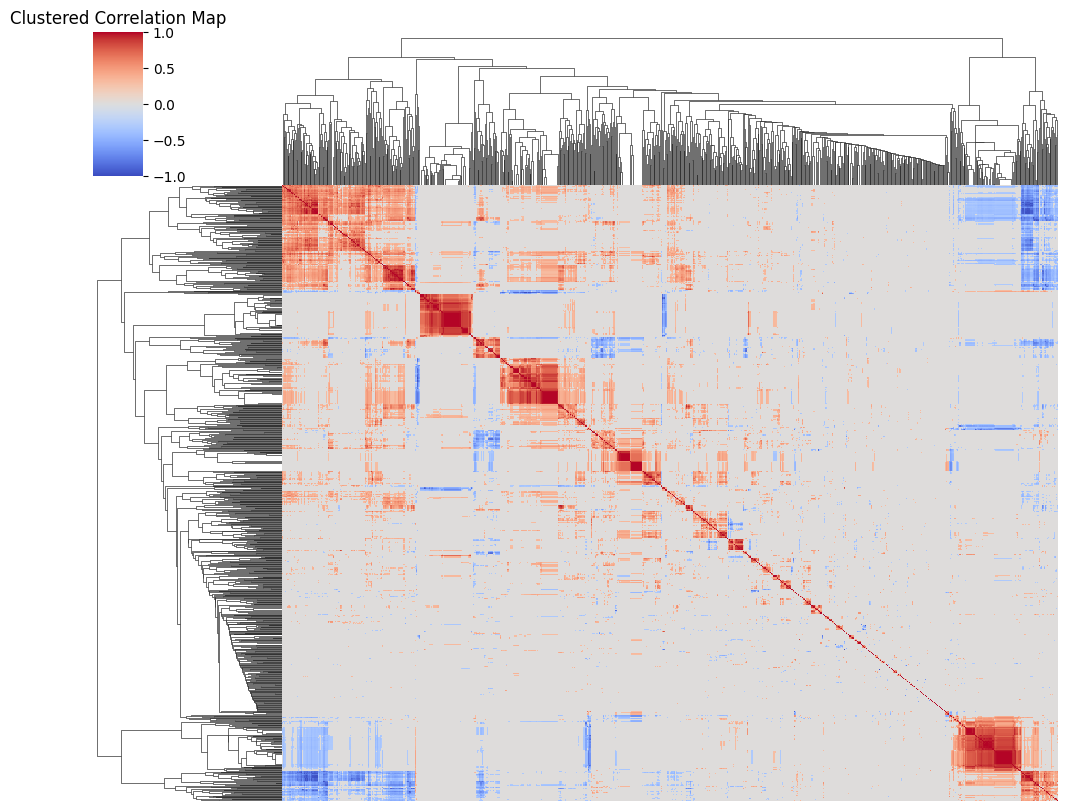

In [424]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = df.drop(["RaceEthnicity", "Income_2"], axis=1).corr()
correlation_matrix.dropna(inplace=True)

# Set a threshold for correlation (adjust as needed)
threshold = 0.3  # You can change this threshold value

# Create a mask to select highly correlated features
highly_correlated = (correlation_matrix.abs() >= threshold) | (correlation_matrix.abs() <= -threshold)

# Apply the mask to the correlation matrix
correlation_matrix_filtered = correlation_matrix.where(highly_correlated)

# Replace NaN values in the filtered correlation matrix with 0
correlation_matrix_filtered.fillna(0.01, inplace=True)

# Create a clustermap to visualize the filtered correlation matrix with clustering
sns.clustermap(correlation_matrix_filtered, cmap='coolwarm', figsize=(10, 8), annot=False,
               row_cluster=True, col_cluster=True,
               xticklabels=False, yticklabels=False)  # Set xticklabels and yticklabels to False
plt.title('Clustered Correlation Map')
plt.show()

In [425]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler  # Import the StandardScaler

# Define the number of folds (5-fold cross-validation)
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define your dataframe df here (including the drop and data preparation steps)

# Initialize lists to store results
fold_data = []  # List to store fold data

# Initialize the StandardScaler
scaler = StandardScaler()

for fold, (train_index, test_index) in enumerate(kf.split(df), 1):
    # Split the data into train and test sets for this fold
    train, test = df.iloc[train_index], df.iloc[test_index]

    y_train = np.array(train["y"]).astype(int)
    train = train.drop('y', axis=1)
    X_train = train.to_numpy(dtype='float64')

    y_testing = np.array(test["y"]).astype(int)
    test = test.drop('y', axis=1)
    X_test = test.to_numpy(dtype='float64')

    # Apply the scaler to X_train and X_test
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Store fold data in a dictionary
    fold_data.append({
        'fold_number': fold,
        'X_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_testing
    })

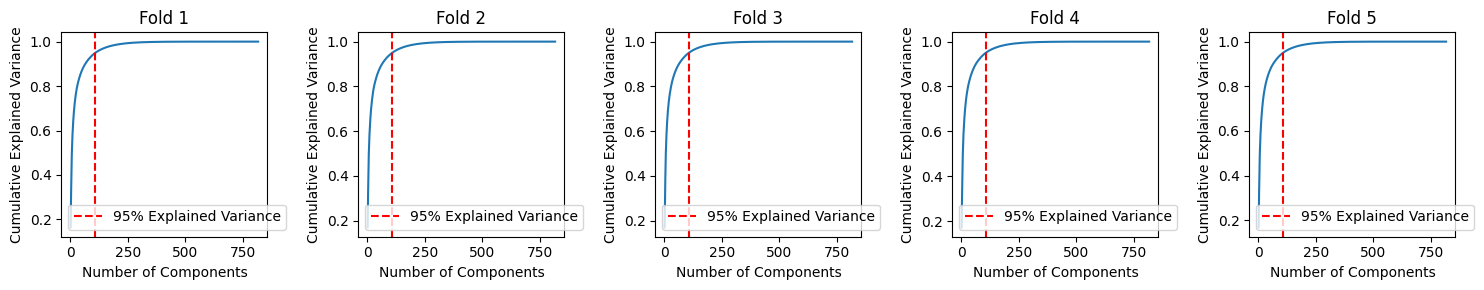

In [426]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Initialize a list to store the number of components for each fold
n_components_95_list = []

# Create a new figure and set of subplots for each fold
fig, axs = plt.subplots(1, 5, figsize=(15, 3))  # Assuming 5 folds

for i in range(0, 5):
    X_train = fold_data[i]['X_train']

    # Create a PCA instance
    pca = PCA()

    # Fit the PCA on your scaled training data (X_train)
    pca.fit(X_train)  # X_train is your scaled training data

    # Calculate the cumulative explained variance
    cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

    # Find the number of components that explain 95% of the total variance
    n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1

    n_components_95_list.append(n_components_95)

    # Plot the cumulative explained variance for this fold
    axs[i].plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio)
    axs[i].set_xlabel('Number of Components')
    axs[i].set_ylabel('Cumulative Explained Variance')
    axs[i].set_title(f'Fold {i + 1}')

    # Highlight the number of components required to explain 95% of the total variance
    axs[i].axvline(x=n_components_95, linestyle='--', color='red', label=f'95% Explained Variance')
    axs[i].legend()

plt.tight_layout()
plt.show()

In [427]:
n_components_95_list

[109, 108, 107, 106, 108]

In [428]:
# Apply PCA for dimensionality reduction
for i in range(0, 5):
    X_train = fold_data[i]['X_train']
    X_test = fold_data[i]['X_test']
    
    pca = PCA(n_components=110)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    fold_data[i]['X_train'] = X_train_pca
    fold_data[i]['X_test'] = X_test_pca

In [437]:
# import numpy as np
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import KFold

# # Set a seed for reproducibility
# seed = 42
# np.random.seed(seed)

# # Initialize lists to store results
# fold_data = []  # List to store fold data

# # Assuming df contains your data
# participants = df['Participant'].unique()
# np.random.shuffle(participants)

# # Initialize the scaler
# scaler = StandardScaler()

# # Create 5-fold cross-validation splits with random participant assortment
# kf = KFold(n_splits=5)

# for train_index, test_index in kf.split(participants):
#     train_participants = participants[train_index]
#     test_participants = participants[test_index]
#     train = df[df['Participant'].isin(train_participants)]
#     test = df[df['Participant'].isin(test_participants)]

#     y_train = np.array(train["y"]).astype(int)
#     train = train.drop(['y', 'Participant'], axis=1)
#     X_train = train.to_numpy(dtype='float64')

#     y_testing = np.array(test["y"]).astype(int)
#     test = test.drop(['y', 'Participant'], axis=1)
#     X_test = test.to_numpy(dtype='float64')
    
#     # Apply the scaler to X_train and X_test
#     X_train = scaler.fit_transform(X_train)
#     X_test = scaler.transform(X_test)

#     # Store fold data in a dictionary
#     fold_data.append({
#         'X_train': X_train,
#         'y_train': y_train,
#         'X_test': X_test,
#         'y_test': y_testing
#     })

# df = df.drop("Participant", axis=1) # You can drop Participant column if needed

## Random Forest

In [438]:
import shap

def shap_analysis(clf, x_testing, df, title):
    feature_names = list(df.drop('y', axis=1).columns)
    explainer = shap.TreeExplainer(clf)
    choosen_instance = x_testing
    shap_values = explainer.shap_values(choosen_instance)
    
    # Set the figure size before generating the Shapley summary plot
    plt.figure(figsize=(12, 8))
    
    # Generate the SHAP summary plot
    shap.summary_plot(shap_values[1], choosen_instance, feature_names=feature_names, plot_type='violin', show=False)

    # Customizations
    plt.title(title, fontsize=14)
    plt.xlabel('SHAP Value (Impact on Model Output)', fontsize=12)

    plt.tight_layout()
#     plt.savefig(output_file)
    plt.show()

def plot_importance_distribution(clf, plot_title, df):
    # Get feature importances
    feature_importances = clf.feature_importances_

    # Create a DataFrame to store feature names and importances
    feature_importance_df = pd.DataFrame({'Feature': df.drop("y", axis=1).columns, 'Importance': feature_importances})

    # Sort the DataFrame by importance values in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Create a bar chart to visualize feature importance with adjusted figure size
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='Importance', y='Feature', data=feature_importance_df[:20], color='steelblue')

    # Set the x-axis limits to be more dynamic
    max_importance = feature_importance_df['Importance'].max()
#     ax.set_xlim(0, 0.01)

    # Customize font sizes for readability
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title(plot_title, fontsize=14)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Customize the appearance further, e.g., adding grid lines
    plt.grid(axis='x', linestyle='--', alpha=0.6)

    # Fine-tune layout
    plt.tight_layout()
    
    plt.show()

In [439]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import numpy as np

# Initialize lists to store scores
accuracy_scores = []
precision_scores = []
sensitivity_scores = []
specificity_scores = []
auc_scores = []  # List for AUC scores

# Loop through the folds (assuming fold_data is defined)
for i in range(5):
    X_train = fold_data[i]['X_train']
    y_train = fold_data[i]['y_train']
    X_test = fold_data[i]['X_test']
    y_test = fold_data[i]['y_test']
    
    # Apply SMOTE
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_training, y_training = smote.fit_resample(X_train, y_train)

    # Train RandomForestClassifier
    clf = RandomForestClassifier(max_depth=30, random_state=0)
    clf.fit(X_training, y_training)
    
#     title = f'SHAP Summary Plot Fold {i+1}'
#     shap_analysis(clf, X_test, df, title)
    
    # Make predictions
    pred = clf.predict(X_test)
    prob = clf.predict_proba(X_test)[:, 1]  # Get probability estimates for the positive class

    # Calculate metrics
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    sensitivity = recall_score(y_test, pred)  # Sensitivity is the same as recall
    cm = confusion_matrix(y_test, pred)
    specificity = cm[0,0] / (cm[0,0] + cm[0,1])
    auc = roc_auc_score(y_test, prob)  # Calculate AUC
    
    # Store metrics
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    sensitivity_scores.append(sensitivity)
    specificity_scores.append(specificity)
    auc_scores.append(auc)  # Store AUC score

# Calculate the mean and standard deviation for each metric
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)

mean_precision = np.mean(precision_scores)
std_precision = np.std(precision_scores)

mean_sensitivity = np.mean(sensitivity_scores)
std_sensitivity = np.std(sensitivity_scores)

mean_specificity = np.mean(specificity_scores)
std_specificity = np.std(specificity_scores)

mean_auc = np.mean(auc_scores)  # Mean AUC
std_auc = np.std(auc_scores)  # Standard deviation of AUC

# Print the mean and standard deviation for each metric
print(f"Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"Precision: {mean_precision:.4f} ± {std_precision:.4f}")
print(f"Sensitivity: {mean_sensitivity:.4f} ± {std_sensitivity:.4f}")
print(f"Specificity: {mean_specificity:.4f} ± {std_specificity:.4f}")
print(f"AUC: {mean_auc:.4f} ± {std_auc:.4f}")  

Accuracy: 0.6784 ± 0.0346
Precision: 0.6310 ± 0.0494
Sensitivity: 0.5407 ± 0.0522
Specificity: 0.7739 ± 0.0404
AUC: 0.7282 ± 0.0350


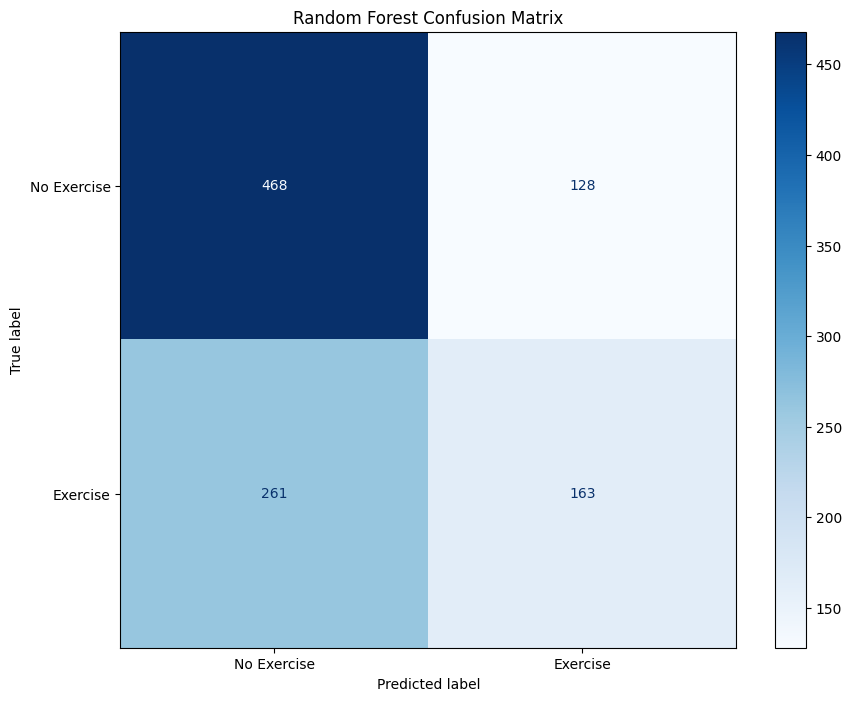

In [440]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

display_labels = ["No Exercise", "Exercise"]
include_values = True
fig, ax = plt.subplots(figsize=(10, 8))

cm_sum = cm_sum.astype(int)

disp = ConfusionMatrixDisplay(confusion_matrix=np.array(cm_sum),
                              display_labels=display_labels)

disp = disp.plot(include_values=include_values,
                 cmap=plt.cm.Blues, ax=ax)
ax.set_title("Random Forest Confusion Matrix")

plt.show()

## Logistic Regression

In [442]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store scores
accuracy_scores = []
auc_scores = []
precision_scores = []
sensitivity_scores = []
specificity_scores = []
feature_importance_sum = np.zeros(X_train.shape[1])  # Assuming X_train is defined

# Assuming fold_data is properly defined and contains your data
for i in range(5):
    X_train = fold_data[i]['X_train']
    y_train = fold_data[i]['y_train']
    X_test = fold_data[i]['X_test']
    y_test = fold_data[i]['y_test']
    
    # Create and fit the Logistic Regression model
    model = LogisticRegression(random_state=0, max_iter=1000)  # Adjust max_iter if needed
    model.fit(X_train, y_train)
    
    # Make predictions and calculate scores
    pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    sensitivity = recall_score(y_test, pred)  # Sensitivity is the same as recall
    cm = confusion_matrix(y_test, pred)
    specificity = cm[0,0] / (cm[0,0] + cm[0,1])
    prob = model.predict_proba(X_test)[:, 1]  # Probability estimates for class 1
    auc = roc_auc_score(y_test, prob)
    
    # Append scores to lists
    accuracy_scores.append(accuracy)
    auc_scores.append(auc)
    precision_scores.append(precision)
    sensitivity_scores.append(sensitivity)
    specificity_scores.append(specificity)
    
    # Store the coefficient values as feature importance
    coef_abs = np.abs(model.coef_[0])
    feature_importance_sum += coef_abs

    # For plotting feature importance, assuming 'df' is defined and contains feature names
    feature_names = df.drop('y', axis=1).columns  # Replace 'target_column' with the actual target column name in your DataFrame
    sorted_indices = np.argsort(coef_abs)[::-1]
    sorted_features = [feature_names[i] for i in sorted_indices]
    sorted_importance = coef_abs[sorted_indices]

# Calculate and print the mean and standard deviation for each score
print(f"Accuracy: {np.mean(accuracy_scores):.4f} ± {np.std(accuracy_scores):.4f}")
print(f"AUC: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")
print(f"Precision: {np.mean(precision_scores):.4f} ± {np.std(precision_scores):.4f}")
print(f"Sensitivity: {np.mean(sensitivity_scores):.4f} ± {np.std(sensitivity_scores):.4f}")
print(f"Specificity: {np.mean(specificity_scores):.4f} ± {np.std(specificity_scores):.4f}")

# Calculate and plot average feature importance
avg_feature_importance = feature_importance_sum / 5  # Since there are 5 folds
sorted_indices = np.argsort(avg_feature_importance)[::-1]
sorted_features = [feature_names[i] for i in sorted_indices]
sorted_importance = avg_feature_importance[sorted_indices]


Accuracy: 0.6941 ± 0.0251
AUC: 0.7478 ± 0.0377
Precision: 0.6557 ± 0.0583
Sensitivity: 0.5468 ± 0.0540
Specificity: 0.7973 ± 0.0285


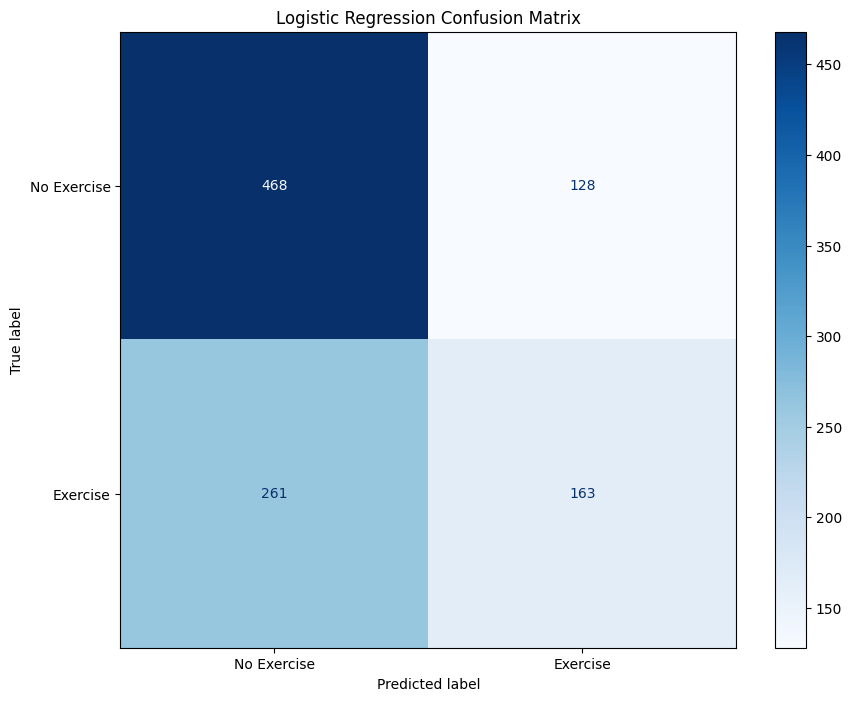

In [443]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

display_labels = ["No Exercise", "Exercise"]
include_values = True
fig, ax = plt.subplots(figsize=(10, 8))

# Calculate the confusion matrix as integers
cm_sum_int = cm_sum.astype(int)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_sum_int,
                              display_labels=display_labels)

disp = disp.plot(include_values=include_values,
                 cmap=plt.cm.Blues, ax=ax)
ax.set_title("Logistic Regression Confusion Matrix")

plt.show()

## Deep Learning

Epoch 1/100
49/49 [==============================] - 1s 6ms/step - loss: 1.8379 - accuracy: 0.5350 - val_loss: 1.5760 - val_accuracy: 0.3763
Epoch 2/100
49/49 [==============================] - 0s 3ms/step - loss: 0.8795 - accuracy: 0.6347 - val_loss: 0.9120 - val_accuracy: 0.5000
Epoch 3/100
49/49 [==============================] - 0s 3ms/step - loss: 0.7063 - accuracy: 0.6580 - val_loss: 0.8673 - val_accuracy: 0.4588
Epoch 4/100
49/49 [==============================] - 0s 3ms/step - loss: 0.6135 - accuracy: 0.7021 - val_loss: 0.7517 - val_accuracy: 0.5258
Epoch 5/100
49/49 [==============================] - 0s 2ms/step - loss: 0.6174 - accuracy: 0.6736 - val_loss: 0.7983 - val_accuracy: 0.4794
Epoch 6/100
49/49 [==============================] - 0s 3ms/step - loss: 0.5504 - accuracy: 0.7085 - val_loss: 0.7813 - val_accuracy: 0.4742
Epoch 7/100
49/49 [==============================] - 0s 3ms/step - loss: 0.5564 - accuracy: 0.7021 - val_loss: 0.7501 - val_accuracy: 0.5103
Epoch 8/100
4

Epoch 59/100
49/49 [==============================] - 0s 2ms/step - loss: 0.2375 - accuracy: 0.8899 - val_loss: 0.3885 - val_accuracy: 0.7938
Epoch 60/100
49/49 [==============================] - 0s 3ms/step - loss: 0.2243 - accuracy: 0.9016 - val_loss: 0.4000 - val_accuracy: 0.7835
Epoch 61/100
49/49 [==============================] - 0s 3ms/step - loss: 0.2390 - accuracy: 0.8886 - val_loss: 0.3411 - val_accuracy: 0.8247
Epoch 62/100
49/49 [==============================] - 0s 2ms/step - loss: 0.2214 - accuracy: 0.8990 - val_loss: 0.4143 - val_accuracy: 0.8093
Epoch 63/100
49/49 [==============================] - 0s 2ms/step - loss: 0.2419 - accuracy: 0.8938 - val_loss: 0.3865 - val_accuracy: 0.7990
Epoch 64/100
49/49 [==============================] - 0s 3ms/step - loss: 0.2156 - accuracy: 0.9067 - val_loss: 0.3938 - val_accuracy: 0.8041
Epoch 65/100
49/49 [==============================] - 0s 2ms/step - loss: 0.2093 - accuracy: 0.9093 - val_loss: 0.3745 - val_accuracy: 0.8299
Epoch 

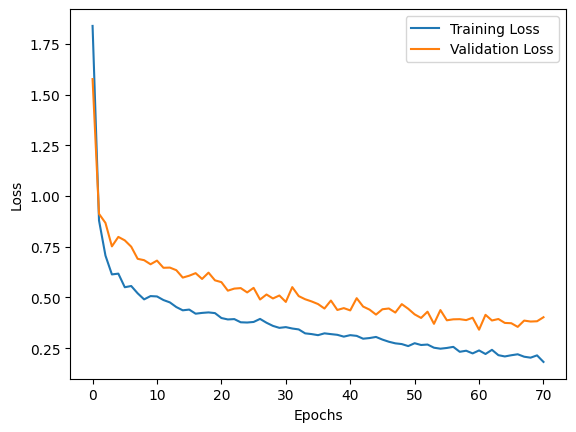

7/7 [==============================] - 0s 1ms/step
Epoch 1/100
49/49 [==============================] - 1s 6ms/step - loss: 1.3615 - accuracy: 0.5528 - val_loss: 1.0651 - val_accuracy: 0.5103
Epoch 2/100
49/49 [==============================] - 0s 3ms/step - loss: 0.9221 - accuracy: 0.6263 - val_loss: 0.7399 - val_accuracy: 0.6031
Epoch 3/100
49/49 [==============================] - 0s 3ms/step - loss: 0.7503 - accuracy: 0.6598 - val_loss: 0.6588 - val_accuracy: 0.5773
Epoch 4/100
49/49 [==============================] - 0s 3ms/step - loss: 0.6622 - accuracy: 0.6817 - val_loss: 0.6862 - val_accuracy: 0.5670
Epoch 5/100
49/49 [==============================] - 0s 3ms/step - loss: 0.5970 - accuracy: 0.7113 - val_loss: 0.7602 - val_accuracy: 0.5361
Epoch 6/100
49/49 [==============================] - 0s 3ms/step - loss: 0.6197 - accuracy: 0.6920 - val_loss: 0.6147 - val_accuracy: 0.5979
Epoch 7/100
49/49 [==============================] - 0s 3ms/step - loss: 0.5309 - accuracy: 0.7255 - va

49/49 [==============================] - 0s 3ms/step - loss: 0.2639 - accuracy: 0.8789 - val_loss: 0.3311 - val_accuracy: 0.8763
Epoch 59/100
49/49 [==============================] - 0s 2ms/step - loss: 0.2405 - accuracy: 0.8853 - val_loss: 0.3481 - val_accuracy: 0.8763
Epoch 60/100
49/49 [==============================] - 0s 2ms/step - loss: 0.2399 - accuracy: 0.8943 - val_loss: 0.3529 - val_accuracy: 0.8918
Epoch 61/100
49/49 [==============================] - 0s 2ms/step - loss: 0.2174 - accuracy: 0.8995 - val_loss: 0.3487 - val_accuracy: 0.9072
Epoch 62/100
49/49 [==============================] - 0s 3ms/step - loss: 0.2277 - accuracy: 0.8982 - val_loss: 0.3677 - val_accuracy: 0.8866
Epoch 63/100
49/49 [==============================] - 0s 3ms/step - loss: 0.2355 - accuracy: 0.8982 - val_loss: 0.3673 - val_accuracy: 0.9021
Epoch 64/100
49/49 [==============================] - 0s 3ms/step - loss: 0.2363 - accuracy: 0.8982 - val_loss: 0.3437 - val_accuracy: 0.9021
Epoch 65/100
49/49 

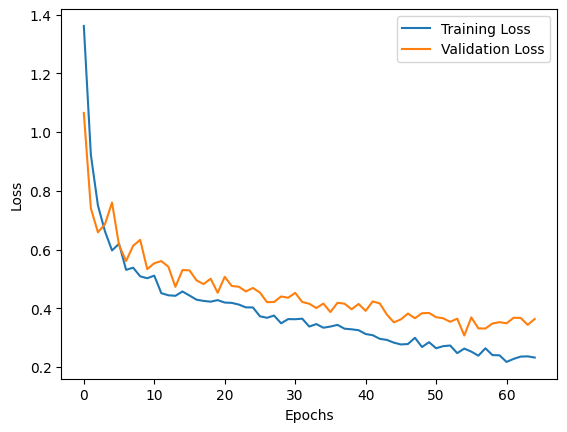

7/7 [==============================] - 0s 1ms/step
Epoch 1/100
48/48 [==============================] - 1s 7ms/step - loss: 1.0216 - accuracy: 0.5762 - val_loss: 0.6985 - val_accuracy: 0.5873
Epoch 2/100
48/48 [==============================] - 0s 3ms/step - loss: 0.7103 - accuracy: 0.6464 - val_loss: 0.6374 - val_accuracy: 0.5873
Epoch 3/100
48/48 [==============================] - 0s 3ms/step - loss: 0.6347 - accuracy: 0.6662 - val_loss: 0.5592 - val_accuracy: 0.6720
Epoch 4/100
48/48 [==============================] - 0s 2ms/step - loss: 0.5964 - accuracy: 0.6848 - val_loss: 0.5670 - val_accuracy: 0.7037
Epoch 5/100
48/48 [==============================] - 0s 3ms/step - loss: 0.5779 - accuracy: 0.6901 - val_loss: 0.5362 - val_accuracy: 0.6931
Epoch 6/100
48/48 [==============================] - 0s 3ms/step - loss: 0.5370 - accuracy: 0.7325 - val_loss: 0.5390 - val_accuracy: 0.6931
Epoch 7/100
48/48 [==============================] - 0s 2ms/step - loss: 0.5107 - accuracy: 0.7377 - va

48/48 [==============================] - 0s 2ms/step - loss: 0.2583 - accuracy: 0.8781 - val_loss: 0.3940 - val_accuracy: 0.8254
Epoch 59/100
48/48 [==============================] - 0s 2ms/step - loss: 0.2237 - accuracy: 0.8967 - val_loss: 0.4046 - val_accuracy: 0.8360
Epoch 60/100
48/48 [==============================] - 0s 2ms/step - loss: 0.2457 - accuracy: 0.8649 - val_loss: 0.3994 - val_accuracy: 0.8307
Epoch 61/100
48/48 [==============================] - 0s 2ms/step - loss: 0.2409 - accuracy: 0.8940 - val_loss: 0.4130 - val_accuracy: 0.8571
Epoch 62/100
48/48 [==============================] - 0s 2ms/step - loss: 0.2389 - accuracy: 0.8781 - val_loss: 0.3925 - val_accuracy: 0.8624
Epoch 63/100
48/48 [==============================] - 0s 2ms/step - loss: 0.2235 - accuracy: 0.8954 - val_loss: 0.3926 - val_accuracy: 0.8624
Epoch 64/100
48/48 [==============================] - 0s 2ms/step - loss: 0.2273 - accuracy: 0.8887 - val_loss: 0.4187 - val_accuracy: 0.8413
Epoch 65/100
48/48 

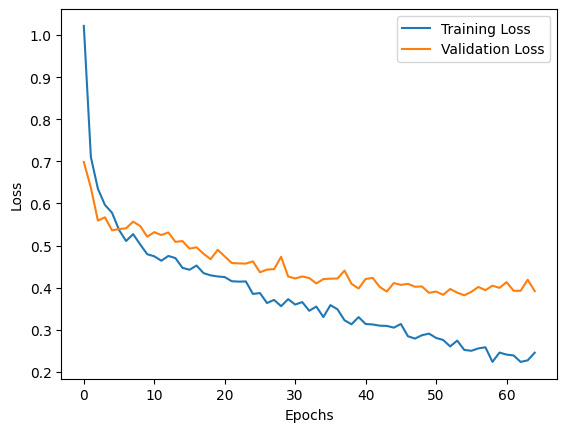

7/7 [==============================] - 0s 1ms/step
Epoch 1/100
48/48 [==============================] - 1s 6ms/step - loss: 1.2866 - accuracy: 0.5414 - val_loss: 0.8622 - val_accuracy: 0.6073
Epoch 2/100
48/48 [==============================] - 0s 3ms/step - loss: 0.8334 - accuracy: 0.6439 - val_loss: 0.7561 - val_accuracy: 0.6021
Epoch 3/100
48/48 [==============================] - 0s 2ms/step - loss: 0.7172 - accuracy: 0.6833 - val_loss: 0.6650 - val_accuracy: 0.5969
Epoch 4/100
48/48 [==============================] - 0s 2ms/step - loss: 0.5981 - accuracy: 0.7017 - val_loss: 0.6456 - val_accuracy: 0.6230
Epoch 5/100
48/48 [==============================] - 0s 2ms/step - loss: 0.6160 - accuracy: 0.6767 - val_loss: 0.6173 - val_accuracy: 0.6283
Epoch 6/100
48/48 [==============================] - 0s 2ms/step - loss: 0.5269 - accuracy: 0.7411 - val_loss: 0.5834 - val_accuracy: 0.6754
Epoch 7/100
48/48 [==============================] - 0s 2ms/step - loss: 0.5167 - accuracy: 0.7332 - va

48/48 [==============================] - 0s 2ms/step - loss: 0.2137 - accuracy: 0.9146 - val_loss: 0.3264 - val_accuracy: 0.8743
Epoch 59/100
48/48 [==============================] - 0s 2ms/step - loss: 0.2069 - accuracy: 0.9054 - val_loss: 0.3323 - val_accuracy: 0.8691
Epoch 60/100
48/48 [==============================] - 0s 2ms/step - loss: 0.2109 - accuracy: 0.9093 - val_loss: 0.3217 - val_accuracy: 0.8482
Epoch 61/100
48/48 [==============================] - 0s 2ms/step - loss: 0.2151 - accuracy: 0.9067 - val_loss: 0.3087 - val_accuracy: 0.8691
Epoch 62/100
48/48 [==============================] - 0s 2ms/step - loss: 0.1974 - accuracy: 0.9146 - val_loss: 0.3239 - val_accuracy: 0.8639
Epoch 63/100
48/48 [==============================] - 0s 2ms/step - loss: 0.2029 - accuracy: 0.9080 - val_loss: 0.3143 - val_accuracy: 0.8691
Epoch 64/100
48/48 [==============================] - 0s 2ms/step - loss: 0.1950 - accuracy: 0.9146 - val_loss: 0.3270 - val_accuracy: 0.8848


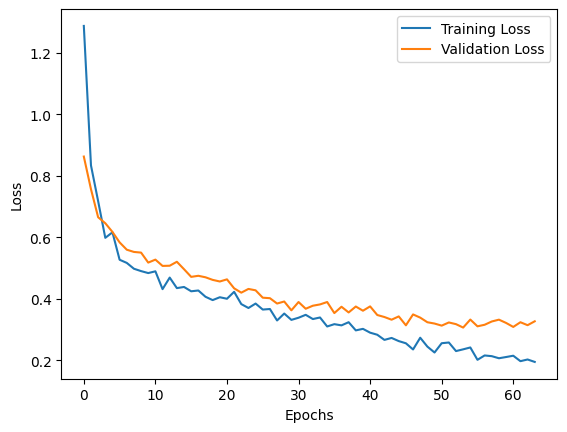

7/7 [==============================] - 0s 1ms/step
Epoch 1/100
47/47 [==============================] - 1s 6ms/step - loss: 1.3606 - accuracy: 0.5561 - val_loss: 0.7154 - val_accuracy: 0.6436
Epoch 2/100
47/47 [==============================] - 0s 2ms/step - loss: 0.9259 - accuracy: 0.6230 - val_loss: 0.7206 - val_accuracy: 0.6383
Epoch 3/100
47/47 [==============================] - 0s 2ms/step - loss: 0.7307 - accuracy: 0.6725 - val_loss: 0.5870 - val_accuracy: 0.6702
Epoch 4/100
47/47 [==============================] - 0s 2ms/step - loss: 0.7168 - accuracy: 0.6725 - val_loss: 0.6197 - val_accuracy: 0.6702
Epoch 5/100
47/47 [==============================] - 0s 2ms/step - loss: 0.5825 - accuracy: 0.7072 - val_loss: 0.5981 - val_accuracy: 0.6702
Epoch 6/100
47/47 [==============================] - 0s 2ms/step - loss: 0.6200 - accuracy: 0.6765 - val_loss: 0.5646 - val_accuracy: 0.6649
Epoch 7/100
47/47 [==============================] - 0s 2ms/step - loss: 0.5570 - accuracy: 0.7166 - va

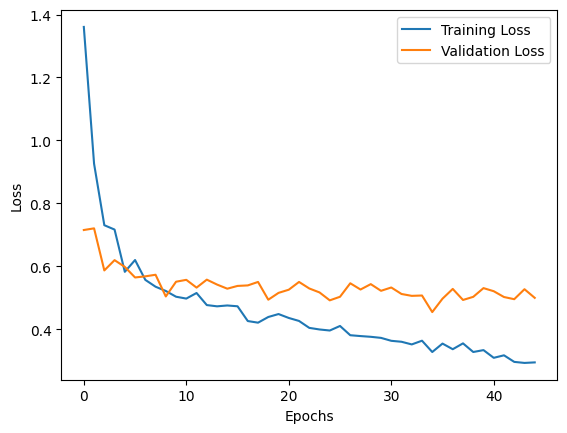

7/7 [==============================] - 0s 1ms/step
Average Accuracy: .75 ± 0.00037
Average AUC: .79 ± 0.00062


In [356]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Initialize lists to store scores and confusion matrices
accuracy_scores = []
auc_scores = []

# Initialize lists to store training and validation loss
training_losses = []
validation_losses = []

# Assuming you have fold_data and SMOTE initialized
for i in range(5):  # Assuming 5-fold cross-validation
    X_train = fold_data[i]['X_train']
    y_train = fold_data[i]['y_train']
    X_test = fold_data[i]['X_test']
    y_test = fold_data[i]['y_test']

    # Apply SMOTE for balancing the training data
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    x_training, y_training = smote.fit_resample(X_train, y_train)

#     # Scale input data
#     scaler = MinMaxScaler()
#     X_scaled = scaler.fit_transform(x_training)

    # Define the neural network model
    model = keras.Sequential([
        layers.Input(shape=(x_training.shape[1],)),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(2, activation="softmax")
    ])

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Create an instance of EarlyStopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history = model.fit(
        x_training, y_training,
        epochs=100,  # Adjust the number of epochs as needed
        batch_size=16,  # Adjust batch size as needed
        verbose=1,
        callbacks=[early_stopping],
        validation_split=0.2  # Split a portion of the data for validation
    )

    # Plot training and validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Predict on the test data
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    accuracy = accuracy_score(y_test, y_pred_labels)
    accuracy_scores.append(accuracy)

    # Calculate AUC
    probabilities = model.predict(X_test)[:, 1]  # Probability of class 1
    auc = roc_auc_score(y_test, probabilities)
    auc_scores.append(auc)

# Calculate and print the average accuracy score
avg_accuracy = np.mean(accuracy_scores)
variance_accuracy = np.var(accuracy_scores)

print(f"Average Accuracy: {avg_accuracy:.2f} ± {variance_accuracy:.5f}")

# Calculate and print the average AUC score
avg_auc = np.mean(auc_scores)
variance_auc = np.var(auc_scores)

print(f"Average AUC: {avg_auc:.2f} ± {variance_auc:.5f}")

7/7 [==============================] - 0s 1ms/step


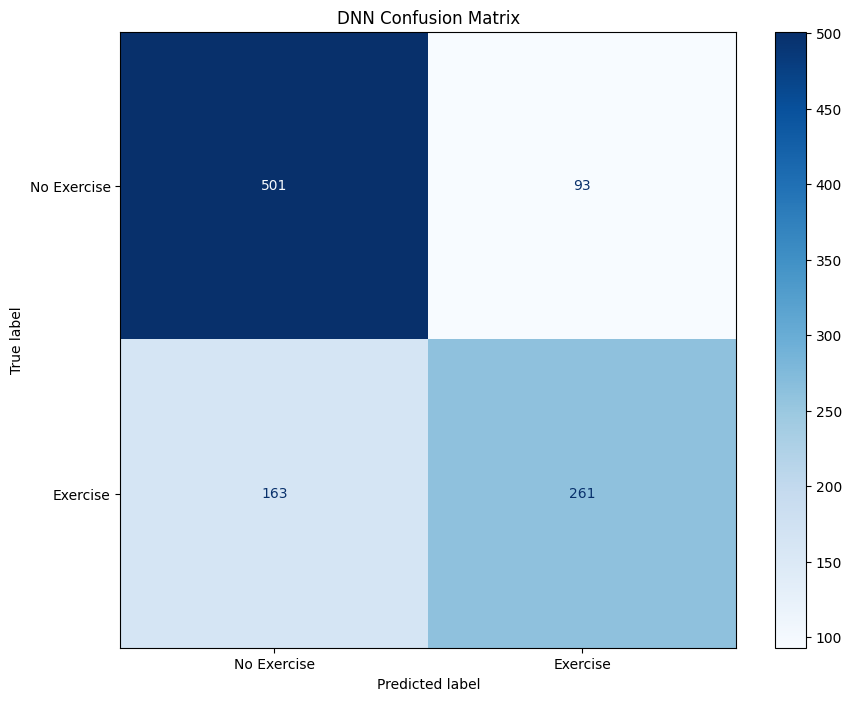

In [357]:
pred = model.predict(np.array(X_test))
from sklearn.metrics import confusion_matrix
cm = cm_1+cm_2+cm_3+cm_4+cm_5

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

display_labels = ["No Exercise", "Exercise"]
include_values = True
fig, ax = plt.subplots(figsize=(10, 8))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=display_labels)

disp = disp.plot(include_values=include_values,
                 cmap=plt.cm.Blues, ax=ax)
ax.set_title("DNN Confusion Matrix")

plt.show()